In [1]:
# You are allowed to use the following modules
from amin_simple import magic_play , animation
import numpy as np
import matplotlib.pyplot as plt


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Your code here
state_num=4
action_num=3
order=5
d=(order+1)**state_num
d_a=d*action_num

def scale(state_):
    a_ = np.array([(state_[0]) / 795,(state_[1]) / 595,(state_[2]+np.pi)/2*np.pi,state_[3]/700])
    return a_

def create_c(k_,n_):#number of states, order
    c_ = [[] for j in range(k_)]
    for i in range(k_):
        for j in range(int(np.power(n_ + 1,i))):
            for p in range(n_ + 1):
                for r in range(int(np.power(n_ + 1,k_- i - 1))):
                    c_[i].append(p)
    c_ = np.array(c_,dtype = np.int8)
    return c_
c=create_c(state_num,order)

def create_x_i(s_,action_index_): #for theta
    state = scale(s_)
    x_i=np.cos(np.pi*(np.matmul(state,c)))
    zero = np.zeros((1,d))
    X_ = np.empty(0)
    for i in range(action_num):
        if i == action_index_:
            X_ = np.append(X_,x_i)
        else:
            X_ = np.append(X_,zero)

    return X_

def create_x_i_v(s_): #for v_hat
    state = scale(s_)
    x_i_=np.cos(np.pi*(np.matmul(state,c)))
    return x_i_


def policy(st,theta):
    h = np.empty(0)
    for i in range(action_num):
        h = np.append(h,np.matmul(theta,create_x_i(st,i)))#theta * x(A_t,S_t
    exp = np.exp(h - np.max(h))
    soft_ = exp / np.sum(exp)

    return soft_

def creat_v_hat(s_in,w_in):
    x_ = create_x_i_v(s_in)
    v_ = np.matmul(w_in,x_)
    return v_ , x_

def nubla_ln_policy(s_,action_index_,theta_):
    x_i_ = create_x_i(s_,action_index_)
    soft_ = policy(s_,theta_)
    sum_ = np.zeros((1,len(x_i_)))
    for i in range(action_num):
        sum_ += soft_[i] * create_x_i(s_,i)
    nubla = x_i_ - sum_
    return nubla
    


In [3]:
def random_play():
    episode = 0
    state_list = []
    step_per_episode = []
    reward_sum = []
    action_list=[]
    player = magic_play()
    
    while episode != 100:
        episode += 1
        t = 0
        action_episode = []
        acc_reward=0
        s = np.zeros((1,4))# states
        angle=(np.pi/32) * 14.5#(np.pi/32) * np.random.choice([i for i in range(1300, 1400)]) * 0.001
        s[0] = [400,574,angle,350]# create the first state in [-.6 -0.4]
        player.game_over = False
        while not player.game_over:
            action_index = np.random.choice(action_num)
            action_episode.append(action_index-1)
            next_state, r_next, game_over = player.move(s[t], action_index-1)
            #print(r_next)
            acc_reward+=r_next
            s = np.append(s,[next_state],axis=0)
            t += 1
        print("ep",episode,"---",acc_reward ,"---")
        action_list.append(action_episode)
        step_per_episode.append(t)
        state_list.append(s)
        reward_sum.append(acc_reward)
    return state_list,step_per_episode , reward_sum, action_list

In [4]:
def Actor_Critic(alpha_theta,alpha_w,Lambda_theta,Lambda_w,num_episod,w_in=np.zeros(0),theta_in=np.zeros(0),player = magic_play()):
    w=np.zeros((1,d))
    if len(w_in)!=0:
        w=w_in
    theta=np.zeros((1,d_a))
    if len(theta_in)!=0:
        theta=theta_in
    episode = 0
    step = np.empty(0)
    state_list = []
    step_per_episode = []
    reward_sum = []
    action_list=[]
    
    while episode != num_episod:
        episode += 1
        z_theta = np.zeros((1,d_a))
        z_w = np.zeros((1,d))
        t = 0
        action_episode = []
        acc_reward=0
        s = np.zeros((1,4))# states
        angle=(np.pi/32) * 14.5#* np.random.choice([i for i in range(1400, 1500)]) * 0.01
        s[0] = [400,574,angle,350]# create the first state in [-.6 -0.4]
        player.game_over = False
        b=1
        while not player.game_over:
            soft_vector = policy(s[t],theta)
            action_index = np.random.choice(action_num,p=soft_vector)
            action_episode.append(action_index-1)
            next_state, r_next, game_over = player.move(s[t], action_index-1)
            #print(r_next)
            acc_reward+=r_next
            s = np.append(s,[next_state],axis=0)
            v_s , x_s= creat_v_hat(s[t],w)
            v_next , _=creat_v_hat(s[t+1],w)
            delta = r_next + v_next - v_s
            z_w = Lambda_w * z_w + x_s
            z_theta = Lambda_theta * z_theta + nubla_ln_policy(s[t],action_index,theta)
            w += alpha_w * delta * z_w
            theta += alpha_theta * delta * z_theta
            t += 1
        print("ep",episode,"---",acc_reward ,"---",soft_vector)
        action_list.append(action_episode)
        step_per_episode.append(t)
        state_list.append(s)
        reward_sum.append(acc_reward)
    return state_list,step_per_episode , reward_sum, action_list,w,theta


In [9]:
state_list , step_per_episode, reward_per_episode,action_list,ww,tt=Actor_Critic(0.00008,0.000075,0.65,0.65,1000)

ep 1 --- -1025.452702985149 --- [0.34429794 0.31826599 0.33743608]
ep 2 --- -1071.6915547442932 --- [0.45356888 0.26021777 0.28621334]
ep 3 --- -1029.0675547442931 --- [5.88024414e-16 5.21421390e-06 9.99994786e-01]
ep 4 --- -1032.8235547442932 --- [2.35604364e-16 1.84896194e-06 9.99998151e-01]
ep 5 --- -1045.0935547442932 --- [1.94001972e-10 9.52402335e-11 1.00000000e+00]
ep 6 --- -1046.1015547442933 --- [2.69479497e-06 9.66086940e-01 3.39103653e-02]
ep 7 --- -1058.935554744293 --- [6.38036810e-18 1.00000000e+00 2.29000634e-10]
ep 8 --- -1049.5575547442932 --- [1.21626103e-06 9.05210307e-01 9.47884763e-02]
ep 9 --- -1055.359554744293 --- [5.57608064e-13 9.99774449e-01 2.25550988e-04]
ep 10 --- -1069.6290332129063 --- [4.20347189e-04 6.37862054e-02 9.35793447e-01]
ep 11 --- -1087.176870518012 --- [2.49734023e-18 9.99999060e-01 9.40054607e-07]
ep 12 --- -1042.8544452557069 --- [2.19766511e-06 7.14550564e-01 2.85447239e-01]
ep 13 --- -1060.382445255707 --- [1.86102189e-11 1.00000000e+00 1

ep 103 --- -1036.5870927177561 --- [3.92736596e-43 1.00000000e+00 8.31340889e-41]
ep 104 --- -1057.7371772506037 --- [1.14567061e-25 1.13419867e-01 8.86580133e-01]
ep 105 --- -1058.66803213528 --- [6.90445845e-31 1.00000000e+00 3.31553755e-15]
ep 106 --- -1057.9611777295486 --- [5.72761148e-32 1.00000000e+00 2.82595161e-16]
ep 107 --- -1059.7370708390301 --- [8.07074267e-32 1.00000000e+00 8.59348018e-16]
ep 108 --- -1045.051763903095 --- [4.27156737e-43 1.00000000e+00 2.33054255e-41]
ep 109 --- -1044.4572757585443 --- [7.97479669e-44 1.00000000e+00 9.14914974e-42]
ep 110 --- -1046.6752916855467 --- [4.48601756e-45 1.00000000e+00 5.32825881e-42]
ep 111 --- -1047.2460269381024 --- [2.76733254e-45 1.00000000e+00 1.73747591e-41]
ep 112 --- -1043.2957302767861 --- [5.13542951e-44 1.00000000e+00 1.49502446e-40]
ep 113 --- -1047.1117302767861 --- [3.92734102e-45 1.00000000e+00 5.75603187e-41]
ep 114 --- -1048.135730276786 --- [6.75055556e-45 1.00000000e+00 1.34942977e-39]
ep 115 --- -1045.527

ep 204 --- -1082.6915547442932 --- [7.69699596e-35 1.00000000e+00 1.76301220e-21]
ep 205 --- -1089.7675547442932 --- [7.11107631e-35 1.00000000e+00 1.58769395e-21]
ep 206 --- -1090.213554744293 --- [4.02387918e-35 1.00000000e+00 2.84982428e-21]
ep 207 --- -1092.1935547442931 --- [1.61393565e-33 1.00000000e+00 2.94032493e-18]
ep 208 --- -1092.7495547442932 --- [1.81846588e-32 1.00000000e+00 3.26032889e-17]
ep 209 --- -1092.1995547442932 --- [2.75991142e-32 1.00000000e+00 3.19845436e-15]
ep 210 --- -1091.977554744293 --- [8.56443959e-36 1.00000000e+00 2.12698177e-21]
ep 211 --- -1090.485554744293 --- [1.09557175e-34 1.00000000e+00 2.62584040e-19]
ep 212 --- -1093.361554744293 --- [2.18118467e-34 1.00000000e+00 1.33357496e-17]
ep 213 --- -1096.3275547442931 --- [1.52174252e-34 1.00000000e+00 7.10166500e-18]
ep 214 --- -1099.675554744293 --- [1.44336934e-34 1.00000000e+00 1.50734296e-17]
ep 215 --- -1096.487554744293 --- [5.01161019e-33 1.00000000e+00 1.08709014e-15]
ep 216 --- -1096.58355

ep 305 --- -1067.947554744293 --- [7.93313802e-41 1.00000000e+00 2.01471873e-32]
ep 306 --- -1067.947554744293 --- [8.71286059e-41 1.00000000e+00 2.23971676e-32]
ep 307 --- -1067.947554744293 --- [9.78569464e-41 1.00000000e+00 2.57537293e-32]
ep 308 --- -1067.947554744293 --- [1.13242567e-40 1.00000000e+00 3.08904903e-32]
ep 309 --- -1067.947554744293 --- [1.36744836e-40 1.00000000e+00 3.92539006e-32]
ep 310 --- -1067.7975547442932 --- [9.10083724e-43 1.00000000e+00 5.52590307e-36]
ep 311 --- -1067.947554744293 --- [3.26755042e-41 1.00000000e+00 4.71523734e-31]
ep 312 --- -1068.043554744293 --- [5.95168291e-41 1.00000000e+00 1.41580959e-30]
ep 313 --- -1068.043554744293 --- [6.22935335e-41 1.00000000e+00 1.35357682e-30]
ep 314 --- -1067.8995547442933 --- [3.39022123e-43 1.00000000e+00 5.57592232e-34]
ep 315 --- -1068.139554744293 --- [2.05494225e-41 1.00000000e+00 1.25799182e-29]
ep 316 --- -1068.043554744293 --- [3.86339028e-42 1.00000000e+00 4.03995150e-29]
ep 317 --- -1068.271554744

ep 407 --- -1067.8995547442933 --- [9.16045159e-41 1.00000000e+00 1.84620075e-33]
ep 408 --- -1067.8995547442933 --- [9.19457439e-41 1.00000000e+00 1.96430661e-33]
ep 409 --- -1067.8995547442933 --- [9.27488130e-41 1.00000000e+00 2.07122716e-33]
ep 410 --- -1067.8995547442933 --- [9.38634250e-41 1.00000000e+00 2.16954311e-33]
ep 411 --- -1067.8995547442933 --- [9.51809978e-41 1.00000000e+00 2.26149714e-33]
ep 412 --- -1067.8995547442933 --- [9.66242173e-41 1.00000000e+00 2.34892113e-33]
ep 413 --- -1067.7975547442932 --- [7.04964226e-39 1.00000000e+00 3.18196927e-35]
ep 414 --- -1067.533554744293 --- [3.35528199e-39 1.00000000e+00 3.76923049e-41]
ep 415 --- -1067.425554744293 --- [1.59781972e-39 1.00000000e+00 2.48620672e-40]
ep 416 --- -1067.425554744293 --- [8.14119865e-39 1.00000000e+00 4.22670018e-40]
ep 417 --- -1067.3655547442931 --- [3.56019425e-40 1.00000000e+00 3.63518796e-43]
ep 418 --- -1067.3655547442931 --- [3.75515784e-40 1.00000000e+00 3.92781746e-43]
ep 419 --- -1067.36

ep 508 --- -1067.2515547442931 --- [5.83093176e-39 1.00000000e+00 2.83570841e-43]
ep 509 --- -1067.3655547442931 --- [2.46140239e-39 1.00000000e+00 7.12127450e-43]
ep 510 --- -1067.2515547442931 --- [3.85706414e-39 1.00000000e+00 4.48288142e-43]
ep 511 --- -1067.2515547442931 --- [4.20962142e-39 1.00000000e+00 4.09450722e-43]
ep 512 --- -1067.2515547442931 --- [4.44214653e-39 1.00000000e+00 3.87015818e-43]
ep 513 --- -1067.2515547442931 --- [4.61375235e-39 1.00000000e+00 3.71855589e-43]
ep 514 --- -1067.2515547442931 --- [4.74610210e-39 1.00000000e+00 3.60909496e-43]
ep 515 --- -1067.2515547442931 --- [4.84997365e-39 1.00000000e+00 3.52756315e-43]
ep 516 --- -1067.2515547442931 --- [4.93172469e-39 1.00000000e+00 3.46611577e-43]
ep 517 --- -1067.2515547442931 --- [4.99556515e-39 1.00000000e+00 3.41991936e-43]
ep 518 --- -1067.2515547442931 --- [5.04452686e-39 1.00000000e+00 3.38576223e-43]
ep 519 --- -1067.2515547442931 --- [5.08093075e-39 1.00000000e+00 3.36139367e-43]
ep 520 --- -1067

ep 608 --- -1067.5935547442932 --- [5.13887705e-37 1.00000000e+00 7.85880020e-34]
ep 609 --- -1067.5935547442932 --- [5.13645763e-37 1.00000000e+00 7.88059435e-34]
ep 610 --- -1067.5935547442932 --- [5.13547604e-37 1.00000000e+00 7.90015987e-34]
ep 611 --- -1067.5935547442932 --- [5.13626374e-37 1.00000000e+00 7.91699240e-34]
ep 612 --- -1067.5935547442932 --- [5.13912279e-37 1.00000000e+00 7.93063019e-34]
ep 613 --- -1067.5935547442932 --- [5.14433424e-37 1.00000000e+00 7.94064485e-34]
ep 614 --- -1067.5935547442932 --- [5.15216875e-37 1.00000000e+00 7.94662888e-34]
ep 615 --- -1067.5935547442932 --- [5.1628987e-37 1.0000000e+00 7.9481814e-34]
ep 616 --- -1067.5935547442932 --- [5.17681133e-37 1.00000000e+00 7.94489294e-34]
ep 617 --- -1067.5935547442932 --- [5.19422315e-37 1.00000000e+00 7.93632928e-34]
ep 618 --- -1067.5935547442932 --- [5.21549640e-37 1.00000000e+00 7.92201377e-34]
ep 619 --- -1067.7495547442932 --- [2.80039283e-34 1.00000000e+00 6.32882986e-30]
ep 620 --- -1067.47

ep 709 --- -1067.5155547442932 --- [2.05906806e-29 1.00000000e+00 1.66151754e-22]
ep 710 --- -1067.5155547442932 --- [2.07347631e-29 1.00000000e+00 1.65322498e-22]
ep 711 --- -1067.425554744293 --- [2.86425975e-20 4.34562725e-02 9.56543728e-01]
ep 712 --- -1067.4335547442931 --- [1.09064175e-23 5.23608454e-11 1.00000000e+00]
ep 713 --- -1067.5815547442933 --- [4.76551167e-22 6.11787395e-06 9.99993882e-01]
ep 714 --- -1067.8755547442931 --- [1.81910069e-27 8.19388302e-17 1.00000000e+00]
ep 715 --- -1067.8755547442931 --- [3.64454980e-27 1.15682291e-16 1.00000000e+00]
ep 716 --- -1067.397554744293 --- [2.99889182e-23 2.74208517e-10 1.00000000e+00]
ep 717 --- -1067.7315547442931 --- [3.4481813e-23 2.9519733e-10 1.0000000e+00]
ep 718 --- -1067.7315547442931 --- [4.21158572e-23 3.28580845e-10 1.00000000e+00]
ep 719 --- -1067.7315547442931 --- [4.97552610e-23 3.60901374e-10 1.00000000e+00]
ep 720 --- -1067.7315547442931 --- [5.64744300e-23 3.89823609e-10 1.00000000e+00]
ep 721 --- -1067.7315

ep 810 --- -1067.7315547442931 --- [2.35340683e-22 3.09895617e-11 1.00000000e+00]
ep 811 --- -1067.5815547442933 --- [2.72582186e-20 9.82322609e-06 9.99990177e-01]
ep 812 --- -1067.7315547442931 --- [4.37322460e-22 3.80353459e-11 1.00000000e+00]
ep 813 --- -1067.5815547442933 --- [1.21886966e-19 1.83058871e-05 9.99981694e-01]
ep 814 --- -1067.5815547442933 --- [9.11556278e-20 1.44487509e-05 9.99985551e-01]
ep 815 --- -1067.5815547442933 --- [4.45077064e-20 8.99870588e-06 9.99991001e-01]
ep 816 --- -1067.5815547442933 --- [9.66929791e-22 1.09881250e-06 9.99998901e-01]
ep 817 --- -1067.7315547442931 --- [4.64976484e-27 7.35255551e-14 1.00000000e+00]
ep 818 --- -1068.013554744293 --- [4.88599556e-33 1.40128724e-25 1.00000000e+00]
ep 819 --- -1068.013554744293 --- [3.95706065e-33 1.26097538e-25 1.00000000e+00]
ep 820 --- -1068.013554744293 --- [2.73587356e-33 1.04843611e-25 1.00000000e+00]
ep 821 --- -1068.013554744293 --- [1.09620415e-33 6.63616051e-26 1.00000000e+00]
ep 822 --- -1068.013

ep 911 --- -1067.7315547442931 --- [8.80688241e-24 3.15830231e-12 1.00000000e+00]
ep 912 --- -1067.7315547442931 --- [8.87056578e-24 3.16426035e-12 1.00000000e+00]
ep 913 --- -1067.7315547442931 --- [8.91317652e-24 3.16613020e-12 1.00000000e+00]
ep 914 --- -1067.7315547442931 --- [8.93496140e-24 3.16401937e-12 1.00000000e+00]
ep 915 --- -1067.7315547442931 --- [8.93457594e-24 3.15772604e-12 1.00000000e+00]
ep 916 --- -1067.7315547442931 --- [8.90930380e-24 3.14678304e-12 1.00000000e+00]
ep 917 --- -1067.7315547442931 --- [8.85526318e-24 3.13049501e-12 1.00000000e+00]
ep 918 --- -1067.7315547442931 --- [8.76757053e-24 3.10796269e-12 1.00000000e+00]
ep 919 --- -1067.7315547442931 --- [8.64042724e-24 3.07808672e-12 1.00000000e+00]
ep 920 --- -1067.7315547442931 --- [8.46709149e-24 3.03954096e-12 1.00000000e+00]
ep 921 --- -1067.8755547442931 --- [1.87130541e-25 1.66235713e-17 1.00000000e+00]
ep 922 --- -1067.7315547442931 --- [1.48303723e-22 1.18902974e-11 1.00000000e+00]
ep 923 --- -1067

In [13]:
show1=animation()
show1.animate(state_list[-400],action_list[-200],100)

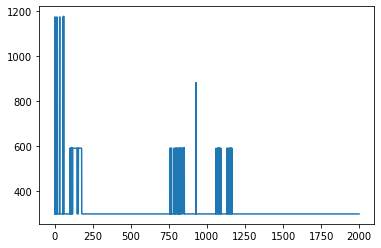

In [7]:
plt.plot(step_per_episode)